In [756]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [757]:
def readData(filename):
    # Daten einlesen
    df = pd.read_csv(filename,
                           sep=';',
                           header=None,
                           names=['Personalnummer', 
                                    'Anrede', 
                                    'Vorname', 
                                    'Nachname',
                                    'Geburtsdatum'],
                            encoding='latin-1') # encoding auf latin-1 da sonst probleme mit Umlauten
    pd.set_option('display.max_columns', None)
    #print(df)
    return df

In [758]:
def is_valid_year(year: str):
    # Testen ob Jahr valide ist
    if year.isdigit() and len(year) == 4:
        if int(year) > 1900 and int(year) < 2006:
            return True
    return False

In [759]:
def is_correctable(birthday):
    # Prüfen ob Datum korrigierbar ist
    if isinstance(birthday, str):
        months = ['Januar','Februar', 'März', 'April', 'Mai', 'Juni', 'Juli', 'August', 'September', 'Oktober', 'November', 'Dezember']
        for m in months:
            if m in birthday:
                new_str = birthday.split(m)[1]
                years = [x for x in new_str.split(' ') if x.isdigit()]
                for year in years:
                    if is_valid_year(year):
                        return months.index(m) + 1, year
                return months.index(m) + 1, None
    return None, None

In [760]:
def get_error_types_and_clean(errorframe, fullframe):
    
    # Erstelle ein neues Dataframe mit den Fehlertypen

    

    for index, row in errorframe.iterrows():
        birthday = row['Geburtsdatum']
        month, year = is_correctable(birthday)
        if month is not None and year is not None:
            datensatz = 'Korrektur'
            typ = 'Monat reicht für Alter'
        elif month is not None:
            datensatz = 'Löschen'
            typ = 'Jahr fehlt'
        elif year is not None:
            datensatz = 'Löschen'
            typ = 'Monat fehlt'
        else:
            datensatz = 'Löschen'
            typ = 'Kein Datum'

        errorframe.loc[index, 'Datensatz?'] = datensatz
        errorframe.loc[index, 'Typ'] = typ


        # Entferne/Korrigiere Datensätze
        if datensatz == 'Löschen':
            fullframe = fullframe.drop(index)
        elif datensatz == 'Korrektur':
            fullframe.loc[index,'Geburtsdatum'] = '01.' + str(month) + '.' + str(year)

    

    

    return fullframe, errorframe

In [761]:
def clean(data):
    cleandata = data.copy()
    errorframe = cleandata.loc[pd.to_datetime(data['Geburtsdatum'], format='%d.%m.%Y',errors='coerce').isna(), ['Personalnummer', 
                                    'Anrede', 
                                    'Vorname', 
                                    'Nachname',
                                    'Geburtsdatum']]
    indizes = [7, 21, 23, 39, 41, 54, 64, 65, 73, 81, 100]
    print(indizes)
    for index in indizes:
        print(index)
        if index == 7:
            datensatz = 'Korrektur'
            typ = 'Falsche Spalte'
            cleandata.at[index, 'Geburtsdatum'] = '16.02.1963'
        elif index == 21:
            datensatz = 'Korrektur'
            typ = 'Monat reicht für Alter'
            cleandata.at[index, 'Geburtsdatum'] = '01.02.1965'
        else:
            datensatz = 'Löschen'
            typ = 'Kein Datum'
            cleandata.drop(index)
        errorframe.loc[index, 'Datensatz?'] = datensatz
        errorframe.loc[index, 'Typ'] = typ
        print(cleandata)
    return cleandata, errorframe

In [762]:
def from_dob_to_age(dob):
    st = datetime(2005,12,31)
    #st = datetime.today()
    a = st.year - dob.year - ((st.month, st.day) < (dob.month, dob.day))
    return a

def get_gender_based_birthdays(data, gender=None):
    # Alle Geburtsdaten des angegebenen Geschlechts
    # Wenn kein Geschlecht angegeben ist gibt diese Funktion alle Geburtstage zurück
    if gender is not None:
        data = data[data['Anrede'] == gender]
    
    # Alter ausrechnen
    
    age = pd.DataFrame(columns=['age'])

    age['age'] = pd.to_datetime(data['Geburtsdatum'], format="%d.%m.%Y").apply(lambda x: from_dob_to_age(x) if from_dob_to_age(x) < 100 else np.nan)
    age = age.dropna()

    
    return age

In [763]:
def age_average(data):
    # Berechne durchschnittliches Alter
    return data['age'].mean()

def age_variance(data):
    # Berechne altersvarianz
    variance = data['age'].var()
    return variance
    
def age_standard_deviation(data):
    # Berechne Standadabweichung
    return data['age'].std()

def get_median(data):
    # Berechne Median
    return data['age'].median()

def get_range(data):
    # Berechne Range
    return data['age'].max() - data['age'].min()

In [764]:
dt = readData('sr_aufg_1_35.txt')

In [765]:
dt_clean, err = clean(dt)

[7, 21, 23, 39, 41, 54, 64, 65, 73, 81, 100]
7
     Personalnummer Anrede            Vorname    Nachname      Geburtsdatum
0                 1   Frau             Dagmar     Gärtner        17.03.1959
1                 2   Herr            Philipp       Baier        16.05.1973
2                 3   Herr            Bertram     Schramm        15.11.1943
3                 4   Frau            Bettina       Kunze        08.07.1974
4                 5   Frau            Tatjana        Koch        04.09.1963
5                 6   Frau              Julia        Lang        05.11.1972
6                 7   Frau             Ursula     Finster        20.03.1980
7                 8   Herr  Siegfried Metzger  16.02.1963        16.02.1963
8                 9   Herr               Axel      Vogler        20.09.1953
9                10   Herr              Frank     Winkler        02.08.1960
10               11   Herr          Friedrich     Schramm        18.01.1978
11               12   Herr             We

In [766]:
err.style

,Personalnummer,Anrede,Vorname,Nachname,Geburtsdatum,Datensatz?,Typ
7,8,Herr,Siegfried Metzger,16.02.1963,nan,Korrektur,Falsche Spalte
21,22,Frau,Elisabeth,Rau,im Februar 1965,Korrektur,Monat reicht für Alter
23,24,Herr,Manfred,Wagner,VHVeHvZZXM,Löschen,Kein Datum
39,40,Herr,Werner,Hartung,27.09.814,Löschen,Kein Datum
41,42,Herr,Christoph,Weiß,,Löschen,Kein Datum
54,55,Frau,Heike,Schneider,unbekannt,Löschen,Kein Datum
64,65,Herr,Oliver,Berger,xxxx,Löschen,Kein Datum
65,66,Herr,Thomas,Alt,20.11.,Löschen,Kein Datum
73,74,Herr,Jochen,Walter,24.10.2824,Löschen,Kein Datum
81,82,Frau,Dorothea,Seidel,xxxx,Löschen,Kein Datum


In [767]:
gbb = get_gender_based_birthdays(dt_clean,'Herr')
male_average = age_average(gbb)
male_variance = age_variance(gbb)
male_standard_deviation = age_standard_deviation(gbb)
male_median = get_median(gbb)
male_range = get_range(gbb)
male_a020 = gbb[gbb['age'].apply(lambda y: y >= 0 and y < 20)]
male_a2030 = gbb[gbb['age'].apply(lambda y: y >= 20 and y < 30)]
male_a3040 = gbb[gbb['age'].apply(lambda y: y >= 30 and y < 40)]
male_a4050 = gbb[gbb['age'].apply(lambda y: y >= 40 and y < 50)]
male_a50 = gbb[gbb['age'].apply(lambda y: y >= 50)]
male_all = gbb['age']

gbb = get_gender_based_birthdays(dt_clean, 'Frau')
female_average = age_average(gbb)
female_variance = age_variance(gbb)
female_standard_deviation = age_standard_deviation(gbb)
female_median = get_median(gbb)
female_range = get_range(gbb)
female_a020 = gbb[gbb['age'].apply(lambda y: y >= 0 and y < 20)]
female_a2030 = gbb[gbb['age'].apply(lambda y: y >= 20 and y < 30)]
female_a3040 = gbb[gbb['age'].apply(lambda y: y >= 30 and y < 40)]
female_a4050 = gbb[gbb['age'].apply(lambda y: y >= 40 and y < 50)]
female_a50 = gbb[gbb['age'].apply(lambda y: y >= 50)]
female_all = gbb['age']

gbb = get_gender_based_birthdays(dt_clean)
average = age_average(gbb)
variance = age_variance(gbb)
standard_deviation = age_standard_deviation(gbb)
median = get_median(gbb)
rng = get_range(gbb)



ValueError: time data 'VHVeHvZZXM' does not match format '%d.%m.%Y' (match)

In [ ]:
ranges = {0 : rng, 1 : female_range, 2 : male_range}
vs = ranges.values()
dat = [ {average, female_average, male_average},
        {variance, female_variance, male_variance},
        {standard_deviation, female_standard_deviation, male_standard_deviation},
        {median, female_median, male_median},
        vs ]

In [ ]:
dataf = pd.DataFrame(dat, columns=['gesamt', 'Frauen', 'Männer'], 
        index=['Mittelwert', 'Varianz', 'Std.-Abw', 'Median', 'Spannweite'])

In [ ]:
dataf.style

,gesamt,Frauen,Männer
Mittelwert,43.862745,36.019608,39.941176
Varianz,153.758882,98.979608,180.240784
Std.-Abw,9.948850,12.399955,13.425378
Median,35.000000,47.000000,39.000000
Spannweite,46.000000,45.000000,46.000000


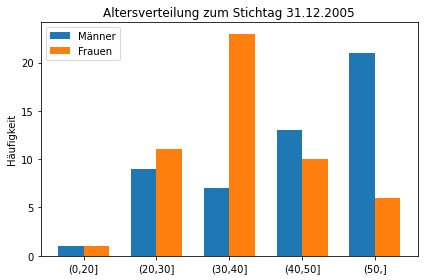

In [ ]:
labels = np.array(['(0,20]','(20,30]','(30,40]','(40,50]','(50,]'])
male = np.array([
    len(male_a020.index),
    len(male_a2030.index),
    len(male_a3040.index),
    len(male_a4050.index),
    len(male_a50.index)
])
female = np.array([
    len(female_a020.index),
    len(female_a2030.index),
    len(female_a3040.index),
    len(female_a4050.index),
    len(female_a50.index)
])
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rect1 = ax.bar(x-width/2,male,width,label="Männer")
rect2 = ax.bar(x+width/2,female,width,label="Frauen")

ax.set_ylabel("Häufigkeit")
ax.set_title("Altersverteilung zum Stichtag 31.12.2005")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar(rect1, padding=6)
#ax.bar(rect2, padding=6)

fig.tight_layout()

plt.show()

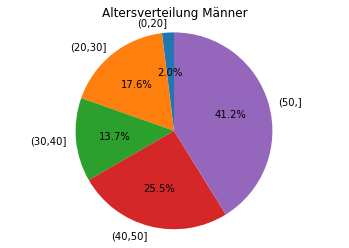

In [ ]:
male_all_count = len(male_all)
labels = ['(0,20]','(20,30]','(30,40]','(40,50]','(50,]']
sizes = [
        len(male_a020)/male_all_count*100,
        len(male_a2030)/male_all_count*100,
        len(male_a3040)/male_all_count*100,
        len(male_a4050)/male_all_count*100,
        len(male_a50)/male_all_count*100
        ]

fig1, ax1 = plt.subplots()
ax1.pie(sizes,labels=labels, autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')
plt.title("Altersverteilung Männer")
plt.show()

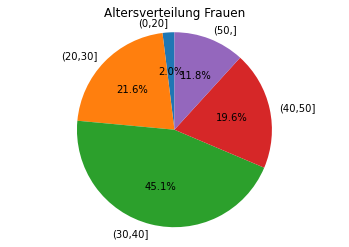

In [ ]:
female_all_count = len(female_all)
sizes = [
        len(female_a020)/female_all_count*100,
        len(female_a2030)/female_all_count*100,
        len(female_a3040)/female_all_count*100,
        len(female_a4050)/female_all_count*100,
        len(female_a50)/female_all_count*100
        ]
fig1, ax1 = plt.subplots()
ax1.pie(sizes,labels=labels, autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')
plt.title("Altersverteilung Frauen")
plt.show()